## 1. Подготовка данных ##

#### 1.1. Установка библиотек, импорты ####

In [1]:

import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk
import nltk
!pip install pymystem3
from pymystem3 import Mystem
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import numpy as np
from matplotlib import cm
import math



%matplotlib inline
sns.set(style="whitegrid")


mystem = Mystem()

#### 1.2. Подготовка датафрейма ####

In [2]:
def cleaner(dataframe):

    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
          dataframe[col] = (dataframe[col]
                              .astype(str)
                              .str.replace(r'\s+', ' ', regex=True)
                              .str.strip()
                              .str.lower())
          dataframe[col] = dataframe[col].replace('nan', np.nan)

    return dataframe

df = pd.read_excel('все_ассоциации_общий файл.xlsx')
df = cleaner(df)
df


,Стимулы,глаз,окно,берег,книга,месяц,орган,журнал,купить,солдат,...,исчезнуть,областной,последний,сложиться,продолжать,необходимый,сегодняшний,политический,рассказывать,правительство
0,NaN,стеклянный,открыто,высокий,настольная,май,бах,мурзилка,продать,удачи,...,навсегда,центр,день,деньгами,нести чушь,предмет,день,конгресс,сплетни,загадка
1,NaN,объектив реальности,рамка бытия,гармония,крепость культуры,циферблат ночи,механизм функционирования,not,not,not,...,призрак,центр,год,пазл,разговор,нужный,денб,скам,язык,государство
2,NaN,зрение,стекло,море,читать,май,сердце,новости,продукты,армия,...,невидимка,номер,день,во времени,рассказ,ингредиент,день,лозунг,историю,россии
3,NaN,зеленый,дверь,моря,писать,май,власти,моды,еду,служба,...,испариться,частный,первый,коробка,ждать,нужный,завтрашний,суд,молчать,надежда
4,NaN,чешется,сверкает,реки,интересная,новый,власти,глянцевый,мороженое,армия,...,пропасть,центр,крайний,в ящик,работу,важный,день,взгляд,иссторию,власть
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,испариться,региональный,крайний,совместиться,следовать дальше,нужный,свежий,политический взгляд,повествование,правительство страны
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,из виду,центр,сезон,судьба,занятие,выбор,день,взгляд,история,президент
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,навсегда,прокурор,день,вместе,делать,предмет,день,спор,история,страны
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,навсегда,больница,герой,в 2 слоя,говорить,ингридиент,день,конфликт,анекдот,россии


## 2. Создаем базовый датафрейм c нужными показателями для дальнейшей обработки ##

#### 2.1. Формирование датафрейма для дальнейшей работы ####

Первичные данные после эксперимента необходимо обработать так, чтобы это было похоже на стандартную словарную статью в ассоциативных словарях. Для этого, в первую очередь, прохожу по каждому стимулу, нахожу совпадающие ассоциации и присваиваю им показатели абсолютной частоты (в рамках ассоциативного поля к каждому стимулу по-отдельности).

In [3]:
df_frequencies = []

for stimulus in df.columns:
    associations = df[stimulus].dropna()
    value_counts = associations.value_counts()

# Меняю расположение колонок в файле. Вертикальный формат с повторением стимулов будет удобней для дальнейшей обработки.

    freq_df = pd.DataFrame({
        'стимул': stimulus,
        'ассоциация': value_counts.index,
        'частота': value_counts.values
    })
    df_frequencies.append(freq_df)

df_frequencies = pd.concat(df_frequencies, ignore_index=True)

df_frequencies.to_excel('обработанные_ассоциации_общий.xlsx', index=False)

display(df_frequencies.head(10))

,стимул,ассоциация,частота
0,глаз,зрение,69
1,глаз,зрачок,29
2,глаз,очки,27
3,глаз,око,26
4,глаз,голубой,24
5,глаз,алмаз,20
6,глаз,видеть,15
7,глаз,нос,14
8,глаз,орган,13
9,глаз,яблоко,13


#### 2.2. Лемматизация и POS-тегинг ####

Для анализа всей сформированной ассоциативно-вербальной сети производим лемматизацию ассоциаций. Этот шаг потом позволит рассмотреть повторяющиеся ассоциации во всей сети, выявить самые частотные. Частеречная разметка необходима, чтобы проводить дальнейшие исследования ассоциативных полей с учетом их грамматических особенностей.

In [4]:
#  новый датафрейм, так как в сохраненном файле нужно было внести изменения.
df2 = pd.read_excel('обработанные_ассоциации_общий_итог.xlsx')
df2

,стимул,ассоциация,частота
0,глаз,зрение,69
1,глаз,зрачок,29
2,глаз,очки,27
3,глаз,око,26
4,глаз,голубой,24
...,...,...,...
77335,правительство,серьезное,1
77336,правительство,народ,1
77337,правительство,боссы,1
77338,правительство,правительство страны,1


In [7]:
# функция для лемматизации и частей речи, так как части речи надо будет определять и для стимулов и для ассоциаций.
def lemmatize_and_tag(text):
    if pd.isna(text) or str(text).strip() == '':  # для пустых ячеек
        return "", ""
    analysis = mystem.analyze(str(text))
    lemmas, pos_tags = [], []
    for item in analysis:
        if 'analysis' in item and item['analysis']:
            lemmas.append(item['analysis'][0]['lex'])
            grammar = item['analysis'][0]['gr']
            pos = grammar.split(',')[0].split('=')[0]
            pos_tags.append(pos)
    return ' '.join(lemmas), '+'.join(pos_tags) # если два слова в ассоциации, то ч.р. прописываю через +

# Для ассоциаций
df2[['лемма', 'часть речи ассоциации']] = df2['ассоциация'].apply(
    lambda x: pd.Series(lemmatize_and_tag(x))
)

# Для стимулов (делаю отдельно, так стимулы повторяются)
stimuli_unique = pd.DataFrame({'стимул': df2['стимул'].unique()})
stimuli_unique['часть речи стимула'] = stimuli_unique['стимул'].apply(
    lambda x: lemmatize_and_tag(x)[1].split('+')[0]
) # среди стимулов есть двойные, это, как правило, две формы глаголов, нам не надо, чтобы тут двойная часть речи через плюс была


df2 = df2.merge(stimuli_unique, on='стимул', how='left')

order = ['стимул', 'часть речи стимула', 'ассоциация', 'частота', 'лемма', 'часть речи ассоциации']
df2 = df2[order]

display(df2.head())

,стимул,часть речи стимула,ассоциация,частота,лемма,часть речи ассоциации
0,глаз,S,зрение,69,зрение,S
1,глаз,S,зрачок,29,зрачок,S
2,глаз,S,очки,27,очки,S
3,глаз,S,око,26,око,S
4,глаз,S,голубой,24,голубой,A


## 3. Обработка лемматизированных ассоциаций ##

#### 3.1. Частоты лемм ####

Пересчитываем частоты лемматизированных ассоциаций: учитываем частоту каждой словоформы.

In [8]:
df_lemmas = df2.groupby(['стимул', 'лемма'], as_index=False)['частота'].sum()

df_lemmas = df_lemmas.sort_values(['стимул', 'частота'], ascending=[True, False])
display(df_lemmas.head().style.hide(axis='index'))

стимул,лемма,частота
история,россия,106
история,мир,21
история,урок,17
история,страна,14
история,рассказ,13


 #### 3.2. Пересечения лемм ####

Смотрим, какие леммы приводились к разным стимулам. Часто повторяющиеся леммы-ассоциации - это ядро ассоциативно-вербальной сети.

In [9]:
# Не учитываю пустые значения (это то, что не смог лемматизировать Mystem, это надо будет потом отдельно проверять)
clean_lemmas = df_lemmas[
    (df_lemmas['лемма'].str.strip() != '') &
    (df_lemmas['лемма'].notna())
].copy()

# Поиск совпадающих лемм у разных стимулов
shared_lemmas = clean_lemmas.groupby('лемма')['стимул'].agg( #группируем все совпадающие леммы
    Количество_стимулов='nunique', #считаем уникальные
    Список_стимулов=lambda x: ', '.join(sorted(x.unique())) # берем только уникальные, сортируем и склеиваем стимулы в одну строку через запятую
).reset_index()


shared_lemmas = shared_lemmas[shared_lemmas['Количество_стимулов'] > 1].sort_values('Количество_стимулов', ascending=False)
shared_lemmas.columns = ['лемма', 'количество стимулов', 'список стимулов']

display(shared_lemmas.head().style.hide(axis='index'))

лемма,количество стимулов,список стимулов
человек,291,"история, обращаться, предыдущий , провести, светлый, экономический, американский, бедный, белый, ближайший, больной, больший, бояться, будущий, бывший, быть, вечный, видеть, воздушный, возникать, возраст, вызывать, высокий, глупый, глядеть, голова, голос, голубой, горный, город, городской, господин, готовый, группа, данные, деревянный, дешевый, длинный, добрый, домашний, достать, древний, духовный, ждать, жесткий, забыть, закрытый, зал, занимать, занять, западный, заставить, звать, звонить, зеленый, земля, земной, знакомый, изменить, иностранный, использовать, казаться, каменный, качество, кивнуть, класс, команда, коммерческий, компания, конечный, конкретный, короткий, крайний, крупный, левый, легкий, лесной, лицо, лишний, маленький, малый, мелкий, мера, местный, метод, мешать, министр, модель, молчать, московский, мягкий, назвать, называть, найти, народ, научный, находиться, небольшой, необходимый, низкий, нормальный, образ, обратиться, общественный, общество, общий, объект, объяснять, обычный, одинаковый, оказаться, оказываться, определенный, организация, основной, оставаться, оставить, остаться, отдельный, открытый, относиться, очередь, память, партийный, партия, площадь, поднять, подойти, позволить (позволять), позиция, показать, показаться, пол, политика, политический, половина, положение, понимать, попросить, последний, последующий, поставить, постоянный, похожий, появляться, правительство, православный, предприятие, председатель, привести, приводить, привыкнуть, прийти, принять, природа, приходиться, промышленный, просить, пространство, процент, прошлый, прямой, пустой, путь, рабочий, равный, разговор, различный, разный, регион, речь, рисунок, род, рост, ряд, связать, связь, святой, сельский, серый, синий, система, слабый, сложный, случайный, слушать, слышать, собрать, совет, советский, совместный, современный, согласиться, сознание, состав, состояние, союз, спокойный, спросить, средний, становиться, старый, стать, структура, судьба, сухой, считать, считаться, твердый, темный, теплый, тип, тихий, тонкий, трудовой, тяжелый, увидеть, удобный, узкий, услышать, устроить, учебный, физический, хватать, хозяин, холодный, частный, человек, человеческий, черный, чистый, чужой, широкий, являться, язык, автор, боевой, брат, военный, волос, врач, встретиться, генерал, глаз, гражданин, губа, давать, девочка, девушка, дерево, директор, доктор, дочь, железный, жена, женщина, завод, крикнуть, мальчик, мама, мать, мертвый, миллион, муж, мужчина, начальник, орган, отец, папа, парень, писатель, поговорить, позвонить, президент, пьяный, рад, ребенок, роман, рука, руководитель, рынок, самолет, солдат, спина, старик, стена, сын, улица, художник, церковь, число"
дом,217,"предыдущий , светлый, американский, бедный, белый, ближайший, больной, больший, будущий, бывший, быть, вечер, вечный, вещь, видеть, воздушный, войти, входить, выйти, высокий, выходить, голубой, горный, город, городской, готовить, готовый, деревянный, держать, детский, дешевый, дойти, домашний, древний, духовный, есть, ждать, забыть, зайти, закрытый, зал, звать, зеленый, земля, земной, идти, каменный, китайский, коммерческий, конкретный, крайний, круглый, крупный, левый, лесной, лишний, маленький, малый, мелкий, местный, место, момент, московский, найти, находиться, небольшой, низкий, номер, нормальный, областной, общественный, общий, объект, обычный, одинаковый, оказаться, оказываться, определенный, основа, основной, оставаться, оставить, остаться, отдельный, открытый, открыть, относиться, передний, площадь, подать, поднять, подойти, поехать, поздний, показать, пол, поле, половина, положение, помнить, попасть, пора, порядок, последний, посмотреть, постоянный, похожий, православный, предприятие, председатель, привести, приводить, привыкнуть, прийти, принести, природа, природный, приходить, проект, промышленный, пространство, прошлый, прямой, пустой, путь, рабочий, равный, размер, разный, район, регион, рисунок, сельский, с

## 4. Статистика: подсчет базовых показателей для ассоциативного словаря, анализ частей речи, TF-IDF, лексическое разнообразие, сила связи ядерных ассоциаций ##

#### 4.1. Количественная характеристика стимулов ####

Для словарных статей ассоциативных словарей, как правило, приводятся следующие количественные показатели к каждому стимулу: а) всего ответов, б) количество различных ассоциаций, в) количество единичных ассоциаций; г) количество отказов.
Формула лексического разнообразию берется из трудов Ю.Н. Караулова, это общепринятая формула в подобных исследованиях.

In [10]:

stats_list = []

for slovo, sub_df in df2.groupby('стимул'):
    total = sub_df['частота'].sum() # всего ответов
    refusals = sub_df[sub_df['ассоциация'] == 'not']['частота'].sum() # сколько отказов
    valid_rows = sub_df[sub_df['ассоциация'] != 'not'] # только ассоциации, без отказов
    distinct = len(valid_rows) # считаем уникальные ассоциации (без отказов)
    singles = len(valid_rows[valid_rows['частота'] == 1]) # одиночные ассоциации

    stats_list.append({
        'стимул': slovo,
        'часть речи стимула': sub_df['часть речи стимула'].iloc[0], # не берем все слов, так как стимулы повторяются
        'всего': total,
        'различные ассоциации': distinct,
        'одиночные ассоциации': singles,
        'отказы': refusals,
        'лексическое разнообразие': round(distinct / total, 3) if total > 0 else 0 # по Караулову
    })

df_summary = pd.DataFrame(stats_list)

display(df_summary.sort_values('лексическое разнообразие', ascending=False).head().style.hide(axis='index'))



стимул,часть речи стимула,всего,различные ассоциации,одиночные ассоциации,отказы,лексическое разнообразие
система,S,500,285,223,1,0.570000
позиция,S,500,276,200,1,0.552000
проект,S,500,274,198,1,0.548000
структура,S,500,264,186,1,0.528000
использовать,V,500,263,203,1,0.526000


#### 4.2. Статистика по частям речи ####

Далее необходимо сделать расчеты касательно частеречных характеристик ассоциаций. В ответах респондентов встречаются ассоциации более чем из одного слова, для таких слов мы проставляли теги частей речи через +, в этой статистики все "плюсовые" теги будем считать в одной группе, это будут ассоциации n-граммы.

In [11]:
# Статистика по частям речи ассоциаций
# собираем список всех уникальных одиночных тегов (S, V, A и т.д.)
all_pos = [tag for tag in df2['часть речи ассоциации'].unique() if "+" not in str(tag) and tag != ""]
# не считаю теги для более чем одного слова (исключаю с +) и исключаем пустые ячейки
pos_data = []
for slovo, sub_df in df2.groupby('стимул'):
    meaningful = sub_df[sub_df['часть речи ассоциации'] != ""] #берем только, те у которых ч.р. определена
    total_m = meaningful['частота'].sum() # считаем их общую частоту

    res = {'стимул': slovo}
    for tag in all_pos:
        count = sub_df[sub_df['часть речи ассоциации'] == tag]['частота'].sum()
        res[f'{tag}_%'] = round(count / total_m * 100, 2) if total_m > 0 else 0
    pos_data.append(res)

df_pos_distribution = pd.DataFrame(pos_data)
# Объединяем со сводной статистикой
df_summary = df_summary.merge(df_pos_distribution, on='стимул')
display(df_summary.head())

,стимул,часть речи стимула,всего,различные ассоциации,одиночные ассоциации,отказы,лексическое разнообразие,S_%,A_%,V_%,...,ADV_%,NUM_%,PART_%,APRO_%,INTJ_%,ANUM_%,ADVPRO_%,CONJ_%,COM_%,PR_%
0,история,S,500,206,151,0,0.412,81.40,9.40,2.40,...,1.00,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
1,обращаться,V,499,204,132,1,0.409,20.68,3.01,15.06,...,9.24,0.0,0.4,0.0,0.2,0.0,0.0,0.0,0.0,0.0
2,объем,S,498,171,109,0,0.343,84.68,10.89,0.40,...,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,предыдущий,A,500,139,81,0,0.278,62.00,29.80,1.60,...,2.20,0.0,0.2,0.4,0.0,0.6,0.0,0.0,0.0,0.4
4,провести,V,499,172,122,0,0.345,83.17,0.40,11.62,...,0.80,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0


Рассчитываем среднее по лексическому разнообразию и медиану. Смотрим отличия среднего лексического разнообразия стимулов разных частей речи от общего среднего.

In [12]:
#  среднее значение по всем стимулам
mean_ttr = df_summary['лексическое разнообразие'].mean()

print(f"Среднее лексическое разнообразие для всего списка стимулов: {mean_ttr:.3f}")

#  медиана
median_ttr = df_summary['лексическое разнообразие'].median()
print(f"Медиана лексического разнообразия: {median_ttr:.3f}")

# среднее л.р. по частям речи стимулов
pos_mean = df_summary.groupby('часть речи стимула')['лексическое разнообразие'].mean().sort_values(ascending=False).reset_index()

print("Среднее лексическое разнообразие в зависимости от ч.р.:")

for index, row in pos_mean.iterrows():

    diff = row['лексическое разнообразие'] - mean_ttr

    mark = "выше среднего" if diff > 0 else "ниже среднего"

    print(f"- {row['часть речи стимула']}: {row['лексическое разнообразие']:.3f} ({mark})")

Среднее лексическое разнообразие для всего списка стимулов: 0.314
Медиана лексического разнообразия: 0.310
Среднее лексическое разнообразие в зависимости от ч.р.:
- V: 0.339 (выше среднего)
- S: 0.324 (выше среднего)
- A: 0.273 (ниже среднего)


#### 4.3. Анализ ядерных ассоциаций ####

Формируем новый датафрейм с ядерными ассоциациями. Рассчитываем силу связи.

In [13]:

# сортировка  по стимулу в алфавитном порядке, затем по частоте (убывание)
df_sorted = df2.sort_values(['стимул', 'частота'], ascending=[True, False])

#  нужна именно словесная ассоциация

df_no_refusals = df_sorted[~df_sorted['ассоциация'].isin(['not'])]

# первую строку для каждого стимула (где самая частотная ассоциация)
df_strongest = df_no_refusals.drop_duplicates('стимул').copy()

# сила связи в процентах
# общее число ответов для каждого стимула из df_summary
if 'df_summary' in locals():
    #
    stats_subset = df_summary[['стимул', 'всего']]
    df_strongest = pd.merge(df_strongest, stats_subset, on='стимул', how='left')

    # частота этой ассоциации / всего ответов на стимул
    df_strongest['сила связи %'] = (
        (df_strongest['частота'] / df_strongest['всего']) * 100
    ).round(2)

cols_order = ['стимул', 'часть речи стимула', 'ассоциация', 'часть речи ассоциации', 'частота', 'сила связи %']
df_strongest = df_strongest[[c for c in cols_order if c in df_strongest.columns]]


df_strongest

,стимул,часть речи стимула,ассоциация,часть речи ассоциации,частота,сила связи %
0,история,S,россии,S,96,19.20
1,обращаться,V,за помощью,PR+S,42,8.42
2,объем,S,литр,S,54,10.84
3,предыдущий,A,следующий,A,68,13.60
4,провести,V,время,S,106,21.24
...,...,...,...,...,...,...
492,церковь,S,крест,S,63,12.94
493,часть,S,тела,S,44,9.11
494,число,S,цифра,S,79,18.54
495,читать,V,книга,S,141,28.83


#### 4.4. TF-IDF ассоциативного поля ####

Рассчитываем TF-IDF. Формируем датафрейм только с уникальными или же самыми характерными ассоциациями-леммами для стимулов.

In [14]:

# Помогал ИИ

corpus = df2.groupby('стимул').apply(
    lambda x: ' '.join([str(row['лемма']) for _, row in x.iterrows() for _ in range(int(row['частота']))]),
    include_groups=False
).reset_index(name='text')
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus['text'])
words = vectorizer.get_feature_names_out()

# индексы максимальных значений в каждой строке матрицы

max_indices = np.array(tfidf_matrix.argmax(axis=1)).flatten()
max_values = np.array(tfidf_matrix.max(axis=1).toarray()).flatten()

# финальный DataFrame
df_tfidf = pd.DataFrame({
    'стимул': corpus['стимул'],
    'характерная лемма': [words[i] for i in max_indices],
    'TF-IDF': np.round(max_values, 4)
})

display(df_tfidf.head())

,стимул,характерная лемма,TF-IDF
0,история,россия,0.9000
1,обращаться,помощь,0.5322
2,объем,литр,0.8395
3,предыдущий,следующий,0.7077
4,провести,время,0.7495


In [15]:
df2 = cleaner(df2)
df_summary = cleaner(df_summary)
df_lemmas = cleaner (df_lemmas)
df_strongest = cleaner (df_strongest)
df_tfidf = cleaner (df_tfidf)
shared_lemmas = cleaner(shared_lemmas)


## 5. Визуализация ##

Облако слов для лемм

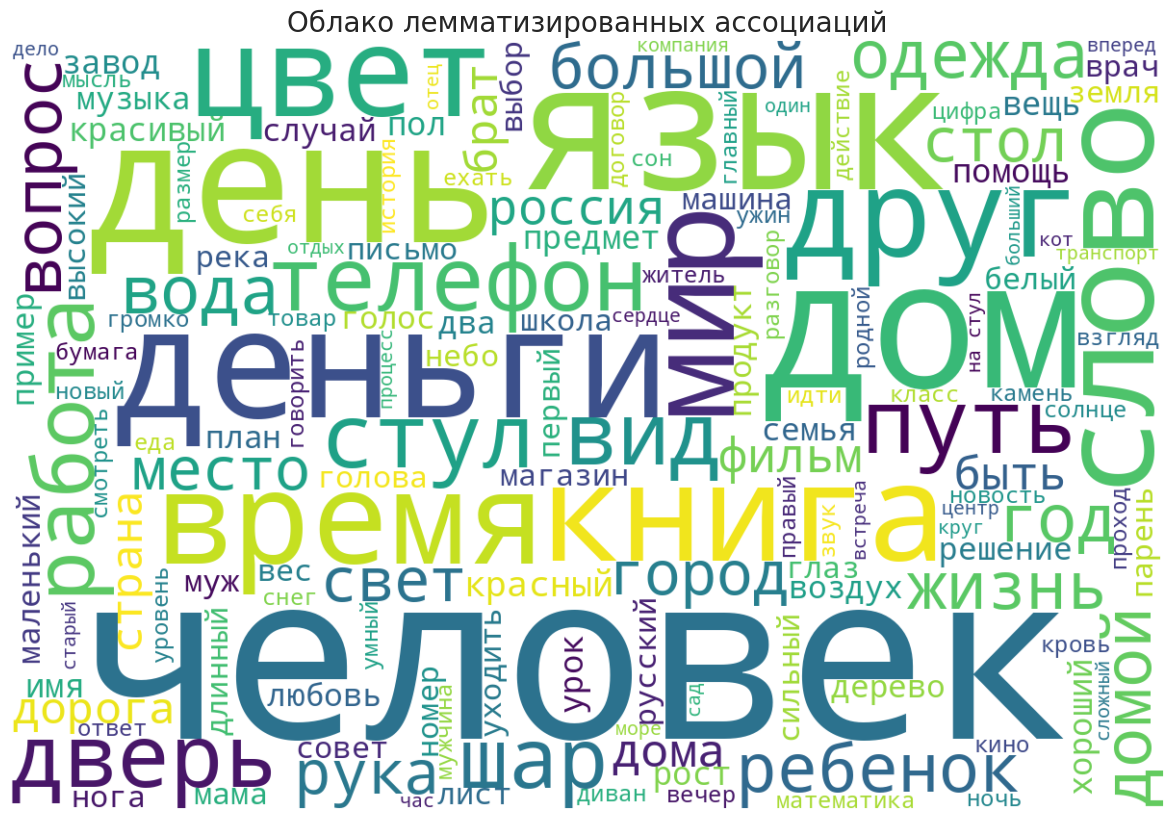

In [16]:
top_lemmas = df_lemmas.groupby('лемма')['частота'].sum().to_dict()

wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=150
).generate_from_frequencies(top_lemmas)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако лемматизированных ассоциаций', fontsize=20)
plt.show()


wordcloud.to_file("wordcloud_associations.png")

График, демонстрирующий распределение коэффициента разнообразия

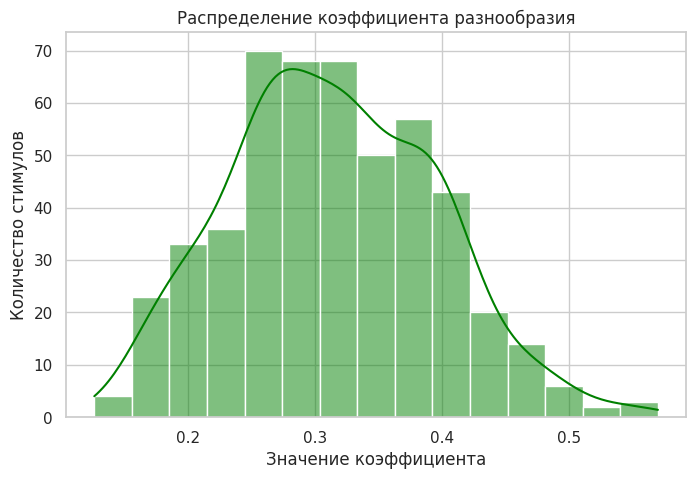

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df_summary['лексическое разнообразие'], bins=15, kde=True, color='green')
plt.title('Распределение коэффициента разнообразия')
plt.xlabel('Значение коэффициента')
plt.ylabel('Количество стимулов')
plt.savefig('распределение ttr.png', dpi=300, bbox_inches='tight')
plt.show()

Построим график для 10 стимулов с самым высоким TTR и с самым низким. И сравним со средним показателем по всем словам.

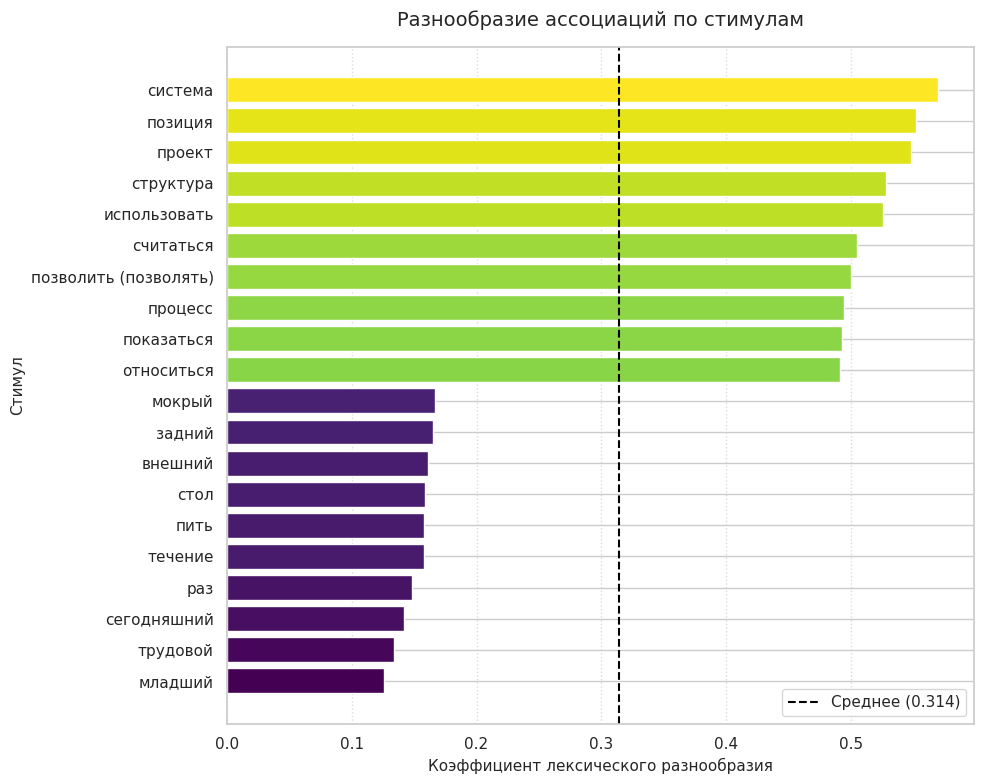

In [18]:
#оформлять помогал ИИ


top_diverse = df_summary.nlargest(10, 'лексическое разнообразие')
bottom_diverse = df_summary.nsmallest(10, 'лексическое разнообразие')
combined = pd.concat([top_diverse, bottom_diverse]).sort_values('лексическое разнообразие')


plt.figure(figsize=(10, 8))

norm = plt.Normalize(combined['лексическое разнообразие'].min(), combined['лексическое разнообразие'].max())
colors = cm.viridis(norm(combined['лексическое разнообразие']))

plt.barh(combined['стимул'], combined['лексическое разнообразие'], color=colors)

mean_val = df_summary['лексическое разнообразие'].mean()
plt.axvline(mean_val, color='black', linestyle='--', linewidth=1.5, label=f'Среднее ({mean_val:.3f})')

plt.title('Разнообразие ассоциаций по стимулам', fontsize=14, pad=15)
plt.xlabel('Коэффициент лексического разнообразия', fontsize=11)
plt.ylabel('Стимул', fontsize=11)
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.savefig('разнообразие_топ.png', dpi=300, bbox_inches='tight')
plt.show()

Рассмотрим взаимосвязь частеречнх характеристик стимула и частеречных характеристик ассоциаиций.

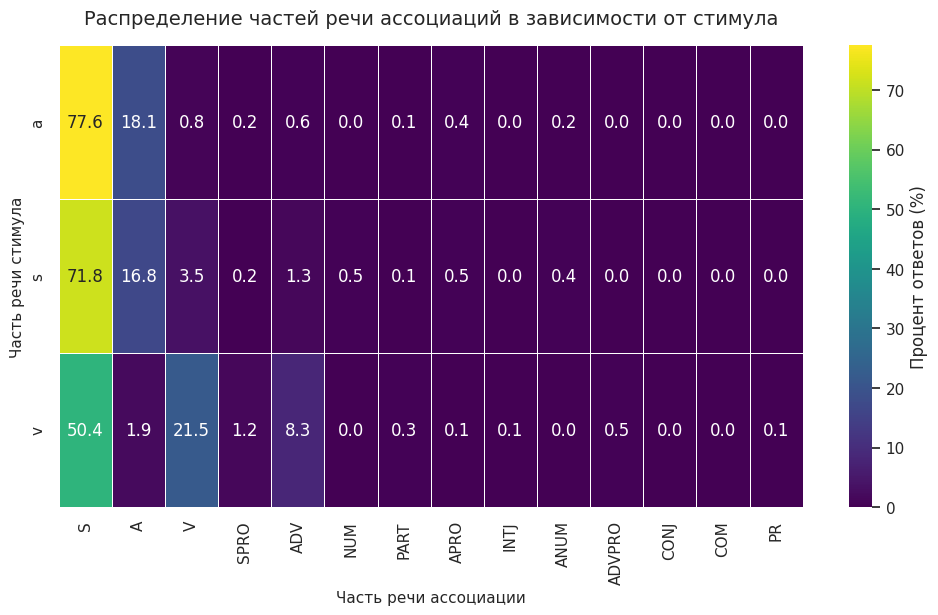

In [19]:
#  список из колонок с процентами частей речи (в БД они заканчиваются на _%)
pos_percent_cols = [i for i in df_summary.columns if i.endswith('_%')] # попробовала метод  endswith()

# группировка в зависимости от части речи стимула и берем среднее по этим колонкам
heatmap_data = df_summary.groupby('часть речи стимула')[pos_percent_cols].mean()


heatmap_data.columns = [c.replace('_%', '') for c in heatmap_data.columns]

plt.figure(figsize=(12, 6))

sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='viridis',
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Процент ответов (%)'}
)

plt.title('Распределение частей речи ассоциаций в зависимости от стимула', fontsize=14, pad=15)
plt.ylabel('Часть речи стимула', fontsize=11)
plt.xlabel('Часть речи ассоциации', fontsize=11)
plt.savefig('pos.png', dpi=300, bbox_inches='tight')
plt.show()

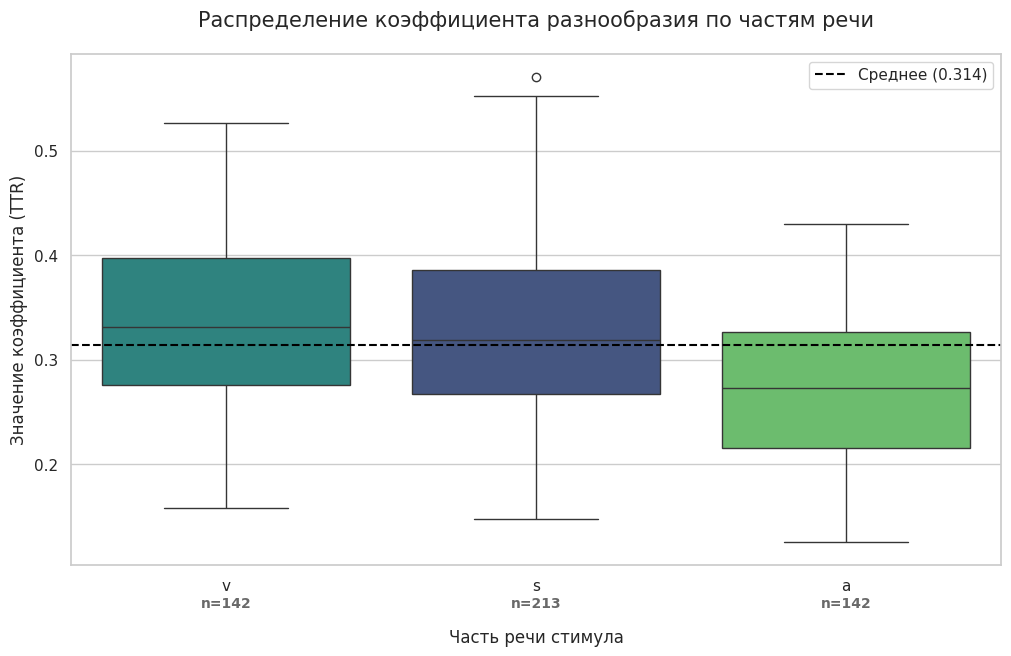

In [20]:

# Этот график помогал строить ИИ


plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# порядок по медиане
order = df_summary.groupby('часть речи стимула')['лексическое разнообразие'].median().sort_values(ascending=False).index

ax = sns.boxplot(
    data=df_summary,
    x='часть речи стимула',
    y='лексическое разнообразие',
    order=order,
    hue='часть речи стимула',
    palette='viridis',
    legend=False
)


mean_val = df_summary['лексическое разнообразие'].mean()
plt.axhline(mean_val, color='black', linestyle='--', label=f'Среднее ({mean_val:.3f})')


plt.title('Распределение коэффициента разнообразия по частям речи', fontsize=15, pad=20)
plt.ylabel('Значение коэффициента (TTR)', fontsize=12)


plt.xlabel('Часть речи стимула', fontsize=12, labelpad=25)

# n=... под осью
for i, pos in enumerate(order):
    count = len(df_summary[df_summary['часть речи стимула'] == pos])
    plt.text(i, plt.gca().get_ylim()[0] - 0.03, f'n={count}',
             ha='center', va='top', fontsize=10, color='dimgray', fontweight='bold')

plt.legend(loc='upper right')


plt.subplots_adjust(bottom=0.15)

plt.savefig('boxplot_ttr_pos.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Выводы на экран ##

Посмотрим стимулы с самым высоким и низким лексическим разнообразием.

In [21]:
# Топ-20 стимулов с высоким л. разнообразием
top_20 = df_summary.nlargest(20, 'лексическое разнообразие')[['стимул', 'лексическое разнообразие', 'различные ассоциации', 'всего']]

print(" ТОП-20 С ВЫСОКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ")
display(top_20.head(20).style.hide(axis='index'))



 ТОП-20 С ВЫСОКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ


стимул,лексическое разнообразие,различные ассоциации,всего
система,0.570000,285,500
позиция,0.552000,276,500
проект,0.548000,274,500
структура,0.528000,264,500
использовать,0.526000,263,500
считаться,0.505000,252,499
позволить (позволять),0.500000,239,478
процесс,0.494000,247,500
показаться,0.493000,246,499
относиться,0.491000,245,499


In [22]:
#Топ-20 стимулов с никзим разнообразием
bottom_20 = df_summary.nsmallest(20, 'лексическое разнообразие')[['стимул', 'лексическое разнообразие', 'различные ассоциации', 'всего']]


print("ТОП-20 С НИЗКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ")
display(bottom_20.head(20).style.hide(axis='index'))

ТОП-20 С НИЗКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ


стимул,лексическое разнообразие,различные ассоциации,всего
младший,0.126000,60,478
трудовой,0.134000,67,500
сегодняшний,0.142000,71,500
раз,0.148000,74,499
пить,0.158000,79,499
течение,0.158000,79,500
стол,0.159000,78,490
внешний,0.161000,80,498
задний,0.165000,79,478
мокрый,0.167000,83,498


Стимулы с самым большим количеством одиночных ассоциаций и с минимальным.

In [23]:
# нужные колонки сортируются по количеству одиночных ассоциаций
top_20_singles = df_summary[['стимул', 'одиночные ассоциации', 'всего']].copy()

top_20_singles = top_20_singles.sort_values('одиночные ассоциации', ascending=False).head(20)

top_20_singles.index = range(1, 21)

print("ТОП-20 СТИМУЛОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ")
display(top_20_singles)

ТОП-20 СТИМУЛОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ


,стимул,одиночные ассоциации,всего
1,система,223,500
2,использовать,203,500
3,позиция,200,500
4,проект,198,500
5,считаться,186,499
6,общество,186,500
7,структура,186,500
8,процесс,185,500
9,показаться,185,499
10,оказываться,183,498


In [24]:
bottom_20_singles = df_summary[['стимул', 'одиночные ассоциации', 'всего']].copy()
bottom_20_singles = bottom_20_singles.sort_values('одиночные ассоциации', ascending=True).head(20)
bottom_20_singles.index = range(1, 21)

print("ТОП-20 СТИМУЛОВ С МИНИМАЛЬНЫМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ")
display(bottom_20_singles)

ТОП-20 СТИМУЛОВ С МИНИМАЛЬНЫМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ


,стимул,одиночные ассоциации,всего
1,месяц,40,488
2,мокрый,44,498
3,стол,44,490
4,младший,44,478
5,желтый,45,498
6,старший,49,498
7,пить,49,499
8,конечный,49,500
9,холодный,50,478
10,сегодняшний,50,500


Ассоциативные пары с самой сильной связью.

In [25]:

top_20_nuclear_pairs = df_strongest[['стимул', 'ассоциация', 'частота', 'сила связи %']].copy()

top_20_nuclear_pairs = top_20_nuclear_pairs.sort_values('частота', ascending=False).head(20)

top_20_nuclear_pairs.index = range(1, 21)

print("ТОП-20 САМЫХ СИЛЬНЫХ АССОЦИАТИВНЫХ ПАР (ЯДРА СЕТИ)")
display(top_20_nuclear_pairs)

ТОП-20 САМЫХ СИЛЬНЫХ АССОЦИАТИВНЫХ ПАР (ЯДРА СЕТИ)


,стимул,ассоциация,частота,сила связи %
1,немецкий,язык,353,70.60
2,сегодняшний,день,329,65.80
3,английский,язык,327,65.53
4,раз,два,316,63.33
5,внешний,вид,295,59.24
6,французский,язык,288,57.83
7,иностранный,язык,277,57.95
8,младший,брат,265,55.44
9,китайский,язык,263,55.02
10,воздушный,шар,262,52.61


## Дополнительно: сетевой анализ ##

Строится однодольная проекция двудольного графа. Узлами будут стимулы. Ребра - общие ассоциации.

In [27]:
#код помогал писать ИИ, методы брала из разных статей адоптировала под свои задачи

stimulus_N = df2.groupby('стимул')['частота'].sum().to_dict()
freq_map = df2.set_index(['стимул', 'лемма'])['частота'].to_dict()

G2 = nx.Graph()

# пересечения из shared_lemmas
for _, row in shared_lemmas.iterrows():
    lemma = row['лемма']
    stims = [s.strip() for s in str(row['список стимулов']).split(',')]

    # без слишком общих лемм
    if len(stims) > 15:
        continue

    for i in range(len(stims)):
        for j in range(i + 1, len(stims)):
            s1, s2 = stims[i], stims[j]

            # частоты
            f_ap = freq_map.get((s1, lemma), 0)
            f_bp = freq_map.get((s2, lemma), 0)
            min_freq = min(f_ap, f_bp)

            if min_freq > 0:
                if G2.has_edge(s1, s2):
                    G2[s1][s2]['sum_min'] += min_freq
                else:
                    G2.add_edge(s1, s2, sum_min=min_freq)

# расчет коэффициента Диза
for u, v, d in list(G2.edges(data=True)):
    Nu = stimulus_N.get(u)
    Nv = stimulus_N.get(v)

    if Nu and Nv:
        denominator = math.sqrt((2 * Nu) * (2 * Nv))
        G2[u][v]['weight'] = d['sum_min'] / denominator
    else:
        G2[u][v]['weight'] = 0

# удаление пустых ребер
G2.remove_edges_from([(u, v) for u, v, d in G2.edges(data=True) if d.get('weight', 0) == 0])

print(f"Узлов: {G2.number_of_nodes()}, Ребер: {G2.number_of_edges()}")

Узлов: 497, Ребер: 47461


In [31]:

edge_data = []
for u, v, d in G2.edges(data=True):
    edge_data.append({
        'Стимул 1': u,
        'Стимул 2': v,
        'Коэффициент Диза': round(d['weight'], 4),
        'Сумма миним. частот': d['sum_min']
    })

df_top_edges = pd.DataFrame(edge_data).sort_values('Коэффициент Диза', ascending=False)

print("ТОП-20 самых сильных ассоциативных связей по Дизу:")
display(df_top_edges.head(20).style.hide(axis='index'))

ТОП-20 самых сильных ассоциативных связей по Дизу:


Стимул 1,Стимул 2,Коэффициент Диза,Сумма миним. частот
сесть,садиться,0.167500,167
церковь,православный,0.136000,134
род,пол,0.112500,110
врач,доктор,0.098100,96
снять,снимать,0.098100,98
машина,автомобиль,0.087900,87
поговорить,разговор,0.084900,84
садиться,сидеть,0.083200,83
повторить,повторять,0.082100,82
поставить,ставить,0.080200,80


In [33]:
# рассчитываем центральности для графа
centrality_degree = nx.degree_centrality(G2)
centrality_betweenness = nx.betweenness_centrality(G2, weight='weight')
centrality_closeness = nx.closeness_centrality(G2)

# таблица метрик
df_graph_metrics = pd.DataFrame({
    'стимул': list(G2.nodes()),
    'количество связей': [d for n, d in G2.degree()],
    'взвешенная степень': [d for n, d in G2.degree(weight='weight')],
    'центральность по степени': [centrality_degree[node] for node in G2.nodes()],
    'степень посредничества': [centrality_betweenness[node] for node in G2.nodes()],
    'степень близости': [centrality_closeness[node] for node in G2.nodes()]
})


df_graph_metrics = df_graph_metrics.sort_values('взвешенная степень', ascending=False)
display(df_graph_metrics.head(10).style.hide(axis='index'))



стимул,количество связей,взвешенная степень,центральность по степени,степень посредничества,степень близости
позиция,339,0.797830,0.683468,0.010528,0.759571
ставить,287,0.746967,0.578629,0.000000,0.703546
состояние,284,0.725282,0.572581,0.000019,0.700565
система,296,0.722042,0.596774,0.008264,0.712644
обращаться,198,0.709867,0.399194,0.000010,0.624685
позволить (позволять),261,0.700532,0.526210,0.000000,0.678523
проект,286,0.691935,0.576613,0.008592,0.702550
структура,290,0.685420,0.584677,0.008254,0.706553
поставить,256,0.681652,0.516129,0.008281,0.673913
поговорить,192,0.669198,0.387097,0.000000,0.620000


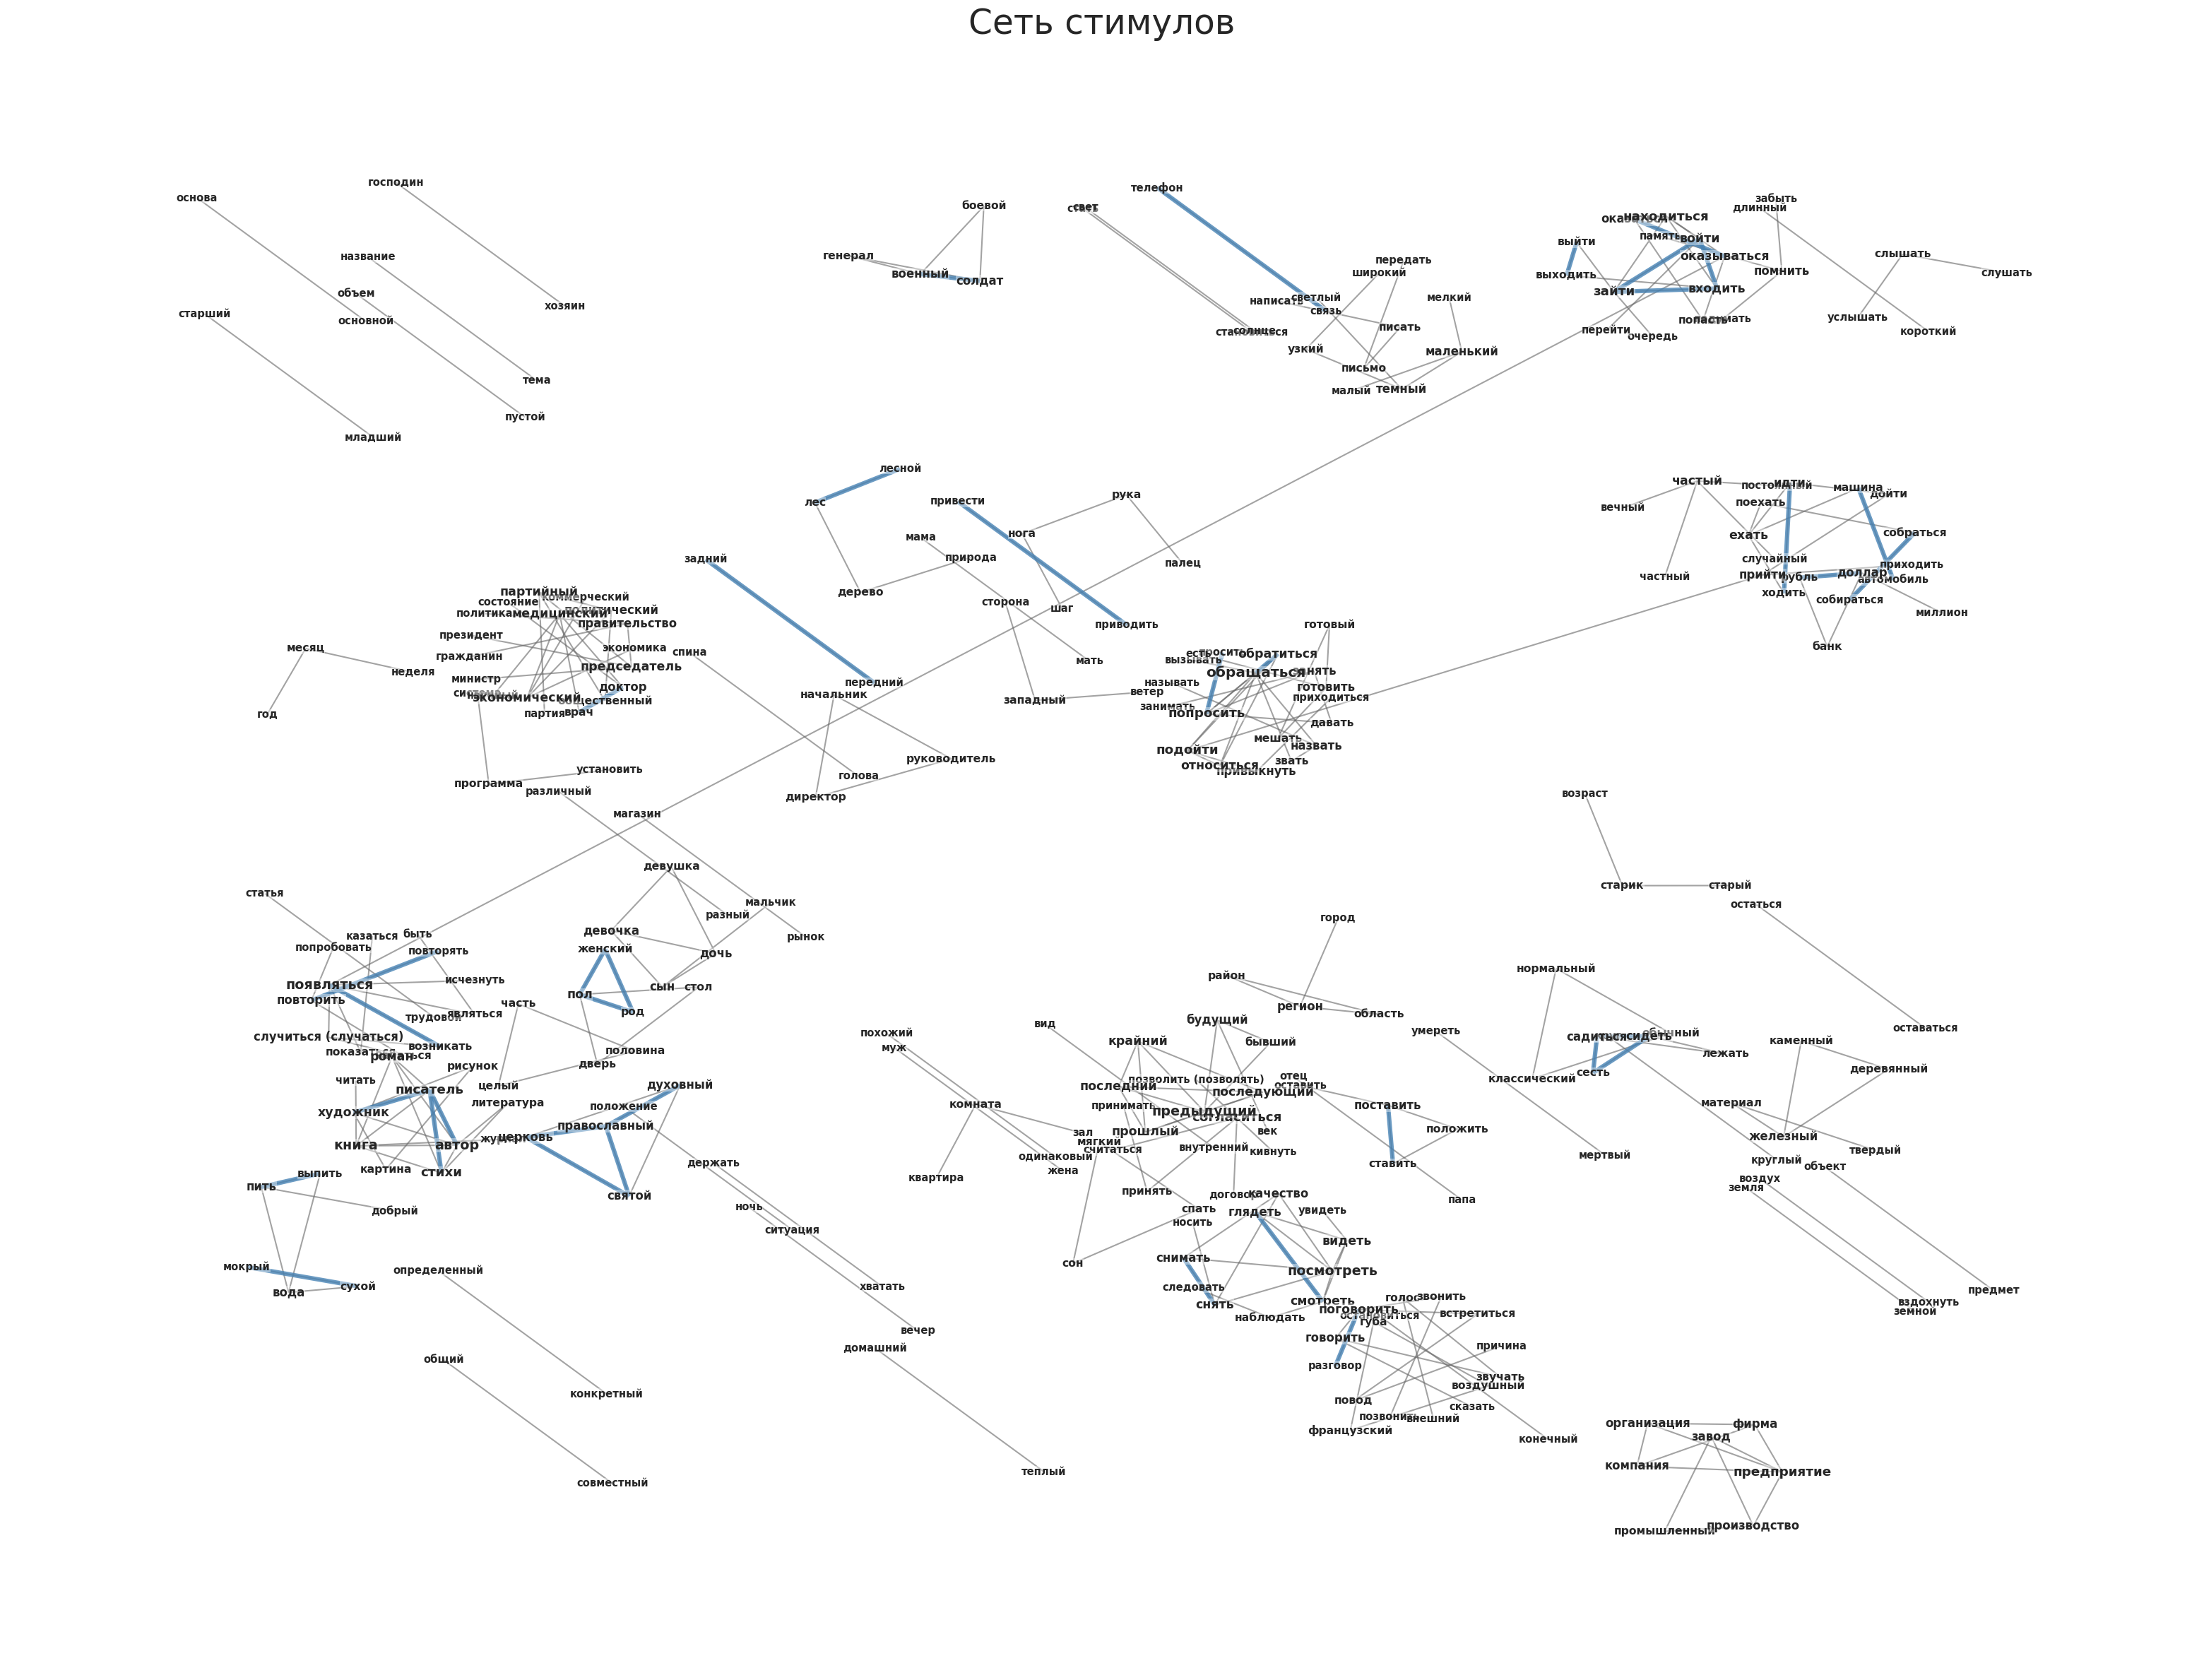

In [41]:
# отрисовка
G2_visual = G2.copy()
threshold_k = 0.018
G2_visual.remove_edges_from([(u, v) for u, v, d in G2_visual.edges(data=True) if d.get('weight', 0) < threshold_k])
G2_visual.remove_nodes_from(list(nx.isolates(G2_visual)))

communities = list(nx.community.greedy_modularity_communities(G2_visual))

plt.figure(figsize=(40, 30))
pos = {}
group_centers = {i: np.random.uniform(-10, 10, size=2) for i in range(len(communities))}

for i, comm in enumerate(communities):
    subgraph = G2_visual.subgraph(comm)
    local_pos = nx.spring_layout(subgraph, k=3.0, iterations=200, seed=42)
    for node in comm:
        pos[node] = local_pos[node] + group_centers[i]

# ребра
# слабые связи
nx.draw_networkx_edges(G2_visual, pos,
                       width=1.5,
                       alpha=0.6,
                       edge_color='#666666')

# сильные связи
strong_edges = [(u, v) for u, v, d in G2_visual.edges(data=True) if d['weight'] > 0.045]
nx.draw_networkx_edges(G2_visual, pos,
                       edgelist=strong_edges,
                       width=4.5,
                       alpha=0.8,
                       edge_color='steelblue')

# текст
centrality = nx.degree_centrality(G2_visual)
sorted_nodes = sorted(G2_visual.nodes(), key=lambda n: centrality[n])

for node in sorted_nodes:
    x, y = pos[node]
    font_sz = 10 + (centrality[node] * 190)

    plt.text(x, y, s=node,
             fontsize=min(font_sz, 24),
             fontweight='bold',
             ha='center', va='center',
             bbox=dict(facecolor='white',
                       alpha=0.4,
                       edgecolor='none',
                       pad=0.1))

plt.axis('off')
plt.title("Сеть стимулов", fontsize=35)
plt.savefig('graph.png', dpi=300, bbox_inches='tight')

plt.savefig('graph.png', dpi=300, bbox_inches='tight')

plt.savefig('graph.pdf', bbox_inches='tight')

plt.show()

In [37]:
# функция для поиска по графу общих лемм-ассоциаций для двух стимулов
def general_lemmas(stim1, stim2, shared_df):

    # по shared_df ищем строки, где оба стимула указаны в списке
    mask = shared_df['список стимулов'].apply(lambda x: stim1 in x and stim2 in x)
    common_lemmas = shared_df[mask].copy()

    if common_lemmas.empty:
        print(f"Общих лемм между '{stim1}' and '{stim2}' в этой таблице не найдено.")
        return

    print(f"Семантический мост: между {stim1} и {stim2}")
    print(f"Всего общих лемм-ассоциаций: {len(common_lemmas)}")

    print("\nОбщие ассоциации:")
    print(", ".join(common_lemmas['лемма'].tolist()))


general_lemmas('папа', 'мама', shared_lemmas)

Семантический мост: между папа и мама
Всего общих лемм-ассоциаций: 34

Общие ассоциации:
человек, дом, хороший, мой, семья, любовь, родной, главный, мама, помощь, любимый, рядом, добрый, радость, спокойствие, защита, злой, любить, родитель, поддержка, добро, уважение, детство, тепло, забота, папа, опора, сложность, доверие, нежность, веселие, воспитание, надежность, доброта


In [38]:
final_file = 'БД ассоциаций_итог.xlsx'

with pd.ExcelWriter(final_file, engine='openpyxl') as writer:
    df2.to_excel(writer, sheet_name='1.Базовый список', index=False)
    df_summary.to_excel(writer, sheet_name='2.Сводная статистика', index=False)
    df_lemmas.to_excel(writer, sheet_name='3.Частоты лемм', index=False)
    df_strongest.to_excel(writer, sheet_name='4.Ядерные ассоциации', index=False)
    shared_lemmas.to_excel(writer, sheet_name='5.Пересечения лемм', index=False)
    df_tfidf.to_excel(writer, sheet_name='6.TF_IDF', index=False)
    df_graph_metrics.to_excel(writer, sheet_name='7.Сетевой анализ', index=False)

